In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Here's an implementation of the Runge Kutta 4th orderd ODE integrator that I have written for a past project of mine
from ODEint import RungeKutta4

from sympy.utilities.autowrap import autowrap

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mpc

mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = "#cdcdcd"
mpl.rcParams['grid.linestyle'] = ":"
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#767afe", "#2b926a", "#b53546", "#e78b50", "#b462be"]) 
mpl.rcParams['font.family'] = 'cmr10'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True

from time import time

# Metric

In [54]:
class Schwarzschild:
    
    def __init__(self, M: float):
        """A class containing all the symbolic calculations for the Schwarzschild metric. Symbolic calculations are performed using the `sympy` package in python. This packages easily handles tensorial calculations and has a nice built-in feature, called `autowrap` that takes a symbolic function and converts it into a C(ython) callable. This has some overhed time for the initial compilation of the function, but it saves a lot of time later when calling the function, speeding up the numerical integration by a factor x10.

        Args:
            M (float): The value of the BH mass in arbitrary units
            
        Attributes:
            x: The symbolic space-time coordinates.
            u: The symbolic components of the tangent vector to a 4-curve.
            g: The matrix rapresention of the metric tensor in the give coordinate system.
            stopping_criterion: A callable function on a geodesic state that returns a boolean value indicating whether a given criterion to stop the geodesic integration has been reached.
        """

        print("Initializing Schwarzschild metric")
              
        # Schwarzschild coordinates
        
        self.M = M

        t, r , theta, phi = sp.symbols("t r theta phi", real = True)
        u_t, u_r , u_theta, u_phi = sp.symbols("u_t u_r u_theta u_phi", real = True)

        self.x = [t, r, theta, phi]
        self.u = [u_t, u_r, u_theta, u_phi]

        # Shcwarzschild metric

        self.g = sp.Matrix(
            [
                [1-2*M/r, 0, 0, 0],
                [0, -1/(1-2*M/r), 0, 0],
                [0, 0, -r**2, 0],
                [0, 0, 0, -r**2*sp.sin(theta)**2]
            ]
        )
        
        """
            In this case the stopping criterion used is that the geodesic doesn't get ``too close'' to the event horizon. This proximity threshold can be reduced (however, when this happens the numerical integration precision has to be increased)
        """
        self.stopping_criterion = lambda state: state[1] >= 2.1*self.M

        print("Computing inverse metric...")
        self.g_inv = self.g.inv()
        
        print("Computing symbolic geodesic equations and cnverting them to Cython callables.")
        self.compile()
        
        print("Done.")

    def christhoffel(self, mu: int, nu: int, rho: int):
        """Computes the Chrishoffel symbols for the metric

        Args:
            mu (int): The upper index in the Christhoffel symbos
            nu (int): The firts lower index.
            rho (int): The second lowe index.

        Returns:
            symbolic: Gamma^mu_{nurho} Christhiffel symbols associated to the metric
        """
        ch = 0
        for sigma in range(4):
            ch += sp.Rational(1/2)*self.g_inv[mu, sigma]*(self.g[sigma, rho].diff(self.x[nu])+self.g[nu, sigma].diff(self.x[rho])-self.g[nu, rho].diff(self.x[sigma]))
        return ch

    def geodesic_eq(self, mu: int):
        """Computes symbolically the right-hand-side of the mu-th geodesic equation associated to the metric

        Args:
            mu (int): The index of the geodesic equations, from 0 to 3.

        Returns:
            symbolic: The symbolic expression of the mu-th godesic equation.
        """
        eq = 0
        for nu in range(4):
            for rho in range(4):
                eq += self.christhoffel(mu, nu, rho)*self.u[nu]*self.u[rho]
        
        return -eq

    def compile(self):
        """A utility function within the metric class that stacks together the geodesic equations computed symbolically, converts them to C callable making use of the 'autowrap' method in Sympy (that automatically creates Cython code and compiles it in the background).
        """
        eq_arr = []
        
        for i in range(4):
            eq_arr.append(autowrap(self.u[i], backend = 'cython', args = [*self.x, *self.u]))
        
        for i in range(4):
            eq_arr.append(autowrap(self.geodesic_eq(i), backend = 'cython', args = [*self.x, *self.u]))
            
        self.update_state = lambda state: np.array([eq(*state) for eq in eq_arr])
        
        """
            The get_u0_[timelike/null] functions are the symbolic representations of the expression of the u_0 component of the tangent trajecotry to a [timelike/null] geodesic that are made callable by the `lambdify` function in sympy (which, differently from `autowrap` returns Python calablle, with zero overhead but longer runtime).
        """
        self.get_u0_timelike = sp.lambdify([*self.x, *self.u[1:]], sp.sqrt(-1-sp.Abs(-self.g[1,1]*self.u[1]**2-self.g[2,2]*self.u[2]**2-self.g[3,3]*self.u[3]**2)/self.g[0,0]))
        self.get_u0_null = sp.lambdify([*self.x, *self.u[1:]], sp.sqrt(sp.Abs(-self.g[1,1]*self.u[1]**2-self.g[2,2]*self.u[2]**2-self.g[3,3]*self.u[3]**2)/self.g[0,0]))
        
        self.get_norm = sp.lambdify([*self.x, *self.u], self.g[0,0]*self.u[0]**2 + self.g[1,1]*self.u[1]**2+self.g[2,2]*self.u[2]**2+self.g[3,3]*self.u[3]**2)
    
    def norm(self, u: np.ndarray, x: np.ndarray) -> float:
        return self.get_norm(*x, *u)

# Geodesic

In [55]:
class NullGeodesic:
    """
        A class to create, initialize and integrate a NullGeodesics in a given metric.
    """
    def __init__(self, metric, integrator, verbose = True):
        """

        Args:
            metric: A metric object like the Schwarzschild metric defined in the previous section of this notebook.
            integrator: An integrator class, like the RungeKutta imported in this notebook.
            verbose (bool, optional): A bool value indicatin wheter to explicitely print information during the geodesic integration. Defaults to True.
        """
        self.metric = metric
        self.integrator = integrator
        self.verbose = verbose
    
    def set_initial_position(self, x: np.ndarray):
        """Set the intial position of the geodesic.

        Args:
            x (np.ndarray): A 4-dimensional array containing the space-time coordinates of the initial position of the geodeisc.
        """
        self.initial_x = x
        
    @property
    def initial_state(self) -> np.ndarray:
        """A class propery computing the initial state of the geodesic. It can be called only after setting the initial position with `set_initial_position` and the initial velocity with `set_initial_spatial_velocity` or by manually assigning a ndarray to the initial_u attribute.

        Returns:
            np.ndarray: An array containing the initial state of the geodesic.
        """
        if not hasattr(self, 'initial_x'):
            raise ValueError("Initial position not set.")
        if not hasattr(self, 'initial_u'):
            raise ValueError("Initial velocity not set.")
        return np.array([*self.initial_x, *self.initial_u])
    
    def set_initial_spatial_velocity(self, u3: np.ndarray):
        """Sets the initial 4-velocity of the geodesic, starting from the spatial components.

        Args:
            u3 (np.ndarray): an array containing the components of the spatial part of the initial tangent-vector to the geodesic.
        """
        if hasattr(self, 'initial_x'):
            u0 = self.metric.get_u0_null(*self.initial_x, *u3)
            self.initial_u = [u0, *u3]
        else:
            raise ValueError("Fix initial position, before fixing initial velocity.")
        
    def integrate(self, tau_0: float, tau_f: float, step: float, **integrator_kwargs):
        """Integrates the geodesic using the Integrator object passed at initialization. The integration is started at proper time [affine parameter] tau_0 and ended at tau_f, if the geodesic is able to arrive at this moment before incurring in a stopping criterions (which are inherited from the metric object). This functions does not return the integrated geodesic, but stores the resulting arrays in the `tau` and `states` arrays.

        Args:
            tau_0 (float): the initial value of the proper time of the integration.
            tau_f (float): the final time of the proper time.
            step (float): the fixed timestep of integration for fixed-step algorithms (like RungeKutta4) or the initial proposed step for adaptive-size integrators (like RungeKuttaFehlberg45)
        """
        if not hasattr(self, 'initial_x'):
            raise ValueError("Set initial position, before integrating.")
        if not hasattr(self, 'initial_u'):
            raise ValueError("Set initial velocity, before integrating.")
        
        
        
        integrator = self.integrator(self.metric.update_state, step, stopping_criterion = self.metric.stopping_criterion, **integrator_kwargs)
        
        start_time = time()
        
        tau, states = integrator.integrate(tau_0, tau_f, np.array([*self.initial_x, *self.initial_u]))        
        end_time = time()
        
        states = np.array(states)
        
        self.tau, self.x, self.u = np.array(tau), states[:,:4], states[:,4:]
        
        if self.verbose:
            print(f"Integration completed in {end_time-start_time} s.")

# Exercise 1

## a) b)

Let's make use of the classes that we have just defined.

First we initialize a `Schwarzschild` metric with mass `M = 1`. This takes a bit of initialization time due to the symbolic computation of the geodesic equations and to their conversion to C callables.

In [56]:
schwarzschild_metric = Schwarzschild(M = 1)

Initializing Schwarzschild metric
Computing inverse metric...
Computing symbolic geodesic equations and cnverting them to Cython callables.
Done.


Now let's define a `NullGeodesic` object, linked to the `schwarzschild_metric` defined in the previous cell and let's pass to it the `RungeKutta4` class to perform the numerical integrations.

We then fix the initial data to
$$
x^{\mu} = (t,\,r,\,\theta,\,\phi) = (0,\,10,\,\pi/2,\,0)
$$
and:
$$
u^\mu = (u^0,\,-1,\,0,u^\phi)
$$

where the component $u^\phi$ is freely specifiable in the variable `dphi_ds` and the $u^0$ component is automatically computed by the `geo.set_initial_spatial_velocity` function.

The geodesic is then integrated.

In [38]:
geo = NullGeodesic(metric = schwarzschild_metric, integrator = RungeKutta4)

dphi_ds = 0.06

geo.set_initial_position([0, 10, np.pi/2, 0])
geo.set_initial_spatial_velocity([-1, 0, dphi_ds])

geo.integrate(0, 100, 0.05)

Integration completed in 0.07445716857910156 s.


Let's plot it in cartesian coordinates.

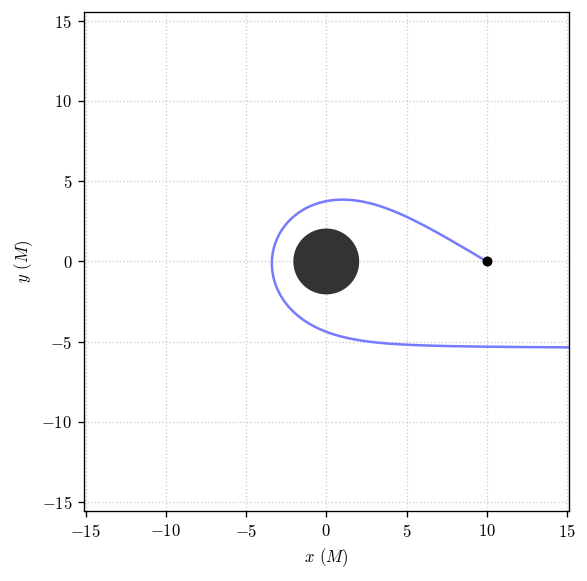

In [25]:
plt.close('all')

fig, ax = plt.subplots(figsize = (5,5))

lim = 15

# Plotting the BH

r_h = 2*schwarzschild_metric.M
phi_h = np.linspace(0, 2*np.pi, 100)

ax.fill(r_h*np.cos(phi_h), r_h*np.sin(phi_h), color = "#333333")

# Converting to geodesic to cartesian and plotting

r = geo.x[:,1]
theta = geo.x[:,2]
phi = geo.x[:,3]

x, y, z = r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)

# Labeling and adjusting the plot

ax.plot(x, y)
ax.plot(x[0], y[0], 'o', markersize = '5', color = 'k')

ax.axis('equal')

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.set_axisbelow(True)

ax.set_xlabel(f'$x$ ($M$)')
ax.set_ylabel(f'$y$ ($M$)')

fig.tight_layout()

## c)

Now we define to auxiliary functions to retrieve the integrate geodesic as a function of $u^\phi$ (i.e. the argument `dphi_ds`) and to add its cartesian representation to a plot.

In [8]:
def get_geodesic(dphi_ds):
    geo = NullGeodesic(metric = schwarzschild_metric, integrator = RungeKutta4)

    geo.set_initial_position([0, 10, np.pi/2, 0])
    geo.set_initial_spatial_velocity([-1, 0, dphi_ds])

    geo.integrate(0, 100, 0.1)
    
    return geo

def plot_geodesic(geo, ax, **plot_kwargs):
    
    r = geo.x[:,1]
    theta = geo.x[:,2]
    phi = geo.x[:,3]

    x, y, z = r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)

    ax.plot(x, y, **plot_kwargs)
    ax.plot(x[0], y[0], 'o', markersize = '5', color = 'k')

Let's draw 25 geodesics with equally spaced values of $u^\phi\in[0,\,0.01]$ 

Integration completed in 0.004294157028198242 s.
Integration completed in 0.0032219886779785156 s.
Integration completed in 0.0034759044647216797 s.
Integration completed in 0.003940105438232422 s.
Integration completed in 0.006124973297119141 s.
Integration completed in 0.003537893295288086 s.
Integration completed in 0.0034151077270507812 s.
Integration completed in 0.002691030502319336 s.
Integration completed in 0.0024912357330322266 s.
Integration completed in 0.0025599002838134766 s.
Integration completed in 0.0025870800018310547 s.
Integration completed in 0.0025780200958251953 s.
Integration completed in 0.002833127975463867 s.
Integration completed in 0.003103017807006836 s.
Integration completed in 0.004128932952880859 s.
Integration completed in 0.027769804000854492 s.
Integration completed in 0.027421236038208008 s.
Integration completed in 0.027205944061279297 s.
Integration completed in 0.027187108993530273 s.
Integration completed in 0.027266979217529297 s.
Integration c

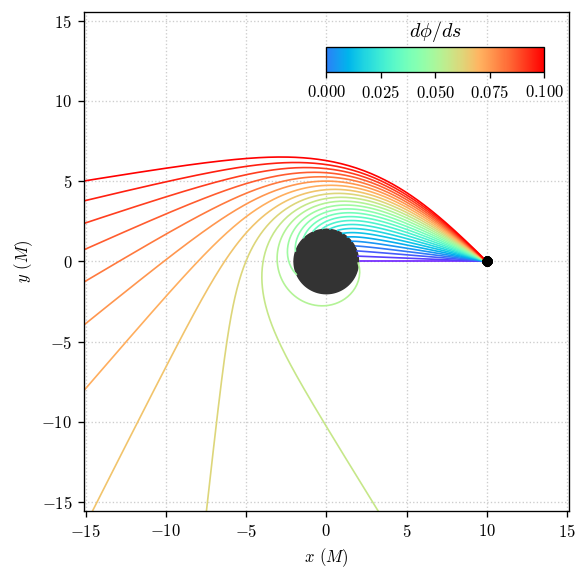

In [26]:
plt.close('all')

fig, ax = plt.subplots(figsize = (5,5))

lim = 15

# Different values of dphi_ds

dphi_ds_arr = np.linspace(0, 0.1, 25)

# Nice-looking colors
cmap = plt.get_cmap('rainbow')
norm = mpc.Normalize(vmin=-0.2*np.max(dphi_ds_arr), vmax=np.max(dphi_ds_arr))
mappable = mpl.cm.ScalarMappable(norm, cmap)

for i, dphi_ds in enumerate(dphi_ds_arr):
    color = cmap((i+1)/len(dphi_ds_arr))
    
    geo = get_geodesic(dphi_ds)
    plot_geodesic(geo, ax, color = color, linewidth = 1)
    
# Plotting the BH

r_h = 2*schwarzschild_metric.M
phi_h = np.linspace(0, 2*np.pi, 100)

ax.fill(r_h*np.cos(phi_h), r_h*np.sin(phi_h), color = "#333333")
    

# Labeling and adjusting the plot

ax.axis('equal')

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.set_axisbelow(True)

ax.set_xlabel(f'$x$ ($M$)')
ax.set_ylabel(f'$y$ ($M$)')

ax_cb = ax.inset_axes((0.5, 0.88, 0.45, 0.05))
ax_cb.grid(False)
cbar = fig.colorbar(mappable, cax=ax_cb, orientation="horizontal")
ax_cb.set_title(r'$d\phi/ds$')
ax_cb.set_xlim(np.min(dphi_ds_arr), np.max(dphi_ds_arr))

fig.tight_layout()


## d)

To validate our code we define a new metric object with `M = 0` and draw a bunch of null geodesics to verify that they will follow straight lines

In [10]:
flat_metric = Schwarzschild(M = 0)

Initializing Schwarzschild metric
Computing inverse metric...
Computing symbolic geodesic equations and cnverting them to Cython callables.
Done.


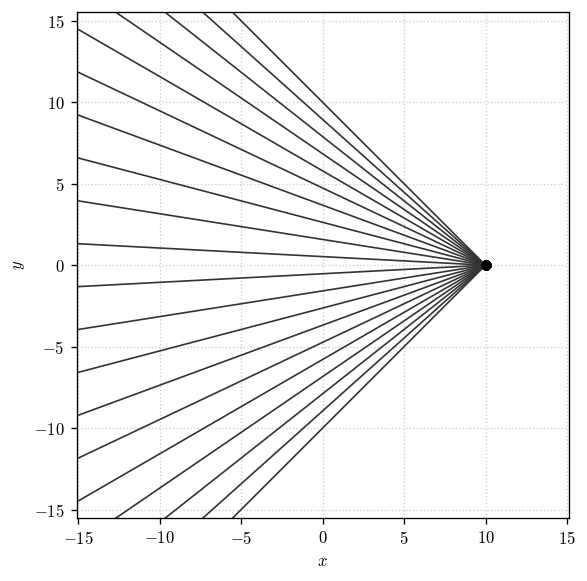

In [11]:
plt.close('all')

fig, ax = plt.subplots(figsize = (5,5))

lim = 15

# Different values of dphi_ds

for dphi_ds in np.linspace(-0.1, 0.1, 20):
    geo = NullGeodesic(metric = flat_metric, integrator = RungeKutta4, verbose = False)

    geo.set_initial_position([0, 10, np.pi/2, 0])
    geo.set_initial_spatial_velocity([-1, 0, dphi_ds])

    geo.integrate(0, 100, 0.1)
    
    plot_geodesic(geo, ax, color = "#343434", linewidth = 1)
    
# Plotting the BH

r_h = 2*flat_metric.M
phi_h = np.linspace(0, 2*np.pi, 100)

ax.fill(r_h*np.cos(phi_h), r_h*np.sin(phi_h), color = "#333333")
    

# Labeling and adjusting the plot

ax.axis('equal')

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.set_axisbelow(True)

ax.set_xlabel(f'$x$')
ax.set_ylabel(f'$y$')

fig.tight_layout()


Finally, in the Schwarzschild case, let's draw the 4-norm of the tangent vector (which should be identically 0) along the geodesic for different values of the integrator time-step. We will particularize this computation for the case of the geodesic integrate in the point (a)

In [72]:
geo = NullGeodesic(metric = schwarzschild_metric, integrator = RungeKutta4)

dphi_ds = 0.06

geo.set_initial_position([0, 10, np.pi/2, 0])
geo.set_initial_spatial_velocity([-1, 0, dphi_ds])

steps_arr = np.logspace(-4, 0, 5)
norm_arr = []
tau_arr = []

for step in steps_arr:
    
    geo.integrate(0, 25, step)
    norm = [schwarzschild_metric.norm(u, x) for x, u in zip(geo.x, geo.u)]
    
    tau_arr.append(geo.tau)
    norm_arr.append(norm)

Integration completed in 7.419421195983887 s.
Integration completed in 0.7271358966827393 s.
Integration completed in 0.06987595558166504 s.
Integration completed in 0.006898164749145508 s.
Integration completed in 0.0007359981536865234 s.


/Users/riccardodellamonica/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  func(*args, **kwargs)


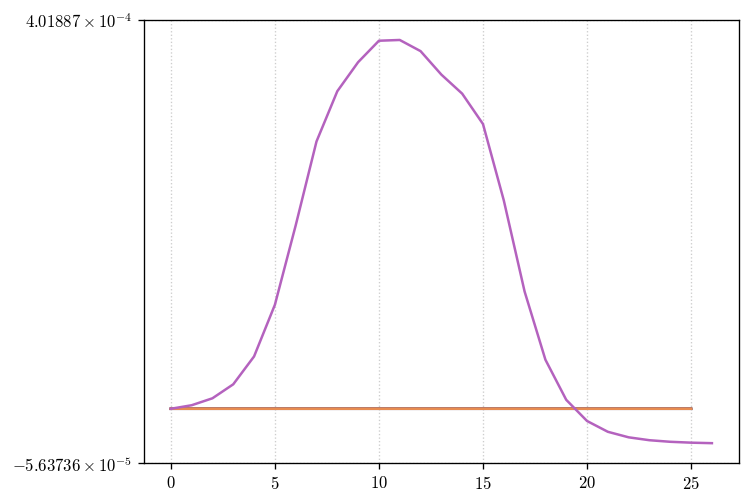

In [74]:
fig, ax = plt.subplots()



ax.plot(tau, norm)